#### Importing

In [1]:
!pip install evaluate

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import evaluate
import numpy as np
import pandas as pd
from transformers import DataCollatorWithPadding

from datasets import load_dataset, DatasetDict, Dataset

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [34]:
from collections import Counter
import torch
from sklearn.utils.class_weight import compute_class_weight


#### DATASET

In [4]:
ds = load_dataset("dair-ai/emotion", "split")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [23]:
train = ds['train']

In [31]:
label_counts = Counter(train['label'])
print(label_counts)

Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})


In [35]:
labels = np.array(train['label'])
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

print("Class weights:", class_weights)


Class weights: [0.57151022 0.49732687 2.04498978 1.23513973 1.37669936 4.66200466]


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights = torch.tensor(class_weights,
                             dtype=torch.float).to(device)

In [37]:
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits.view(-1, model.config.num_labels),
                    labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [7]:
id2labels = {0: 'sadness',
             1: 'joy',
             2: 'love',
             3: 'anger',
             4: 'fear',
             5: 'surprise'}

labels2id = {
    'sadness': 0,
    'joy' : 1,
    'love': 2,
    'anger':3,
    'fear' : 4,
    'surprise' : 5
}

#### model

In [ ]:
model_path = "distilbert/distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_path)


In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels = 6, id2label=id2labels, label2id = labels2id,)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Setting trainable params

In [9]:
for name, param in model. base_model.named_parameters(): # loop through all the params and freeze all.
    param.requires_grad = False

In [10]:
for name,param in model.base_model.named_parameters():
    # loop through all the params again and if pooler name is found, unfreeze it.
    if "pooler" in name:
        param.requires_grad = True

#### Data Preprocessing

In [11]:
def preprocess(ex):
    return tokenizer(ex['text'], truncation=True)

token_data = ds.map(preprocess, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [12]:
token_data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [13]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)  # we need to have same size example in a batch while training.

#### Evaluation metric

In [14]:
acc = evaluate.load("accuracy")


In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": acc.compute(predictions=preds, references=labels)["accuracy"]}


#### Training

In [17]:
training_args = TrainingArguments(
    output_dir="bert",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_dir="./logs",
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",

)


In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=token_data['train'],
    eval_dataset=token_data['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    compute_loss_func=compute_loss
)



/tmp/ipython-input-2806546038.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
from transformers import TrainerCallback

class PrintMetricsCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            print(f"\nEpoch {int(state.epoch)} | Eval Loss: {metrics['eval_loss']:.4f} | Eval Accuracy: {metrics.get('eval_accuracy', 0):.4f}")

trainer.add_callback(PrintMetricsCallback)

In [20]:
trainer.train()
trainer.save_model("bert/final_model")



Epoch,Training Loss,Validation Loss,Accuracy
1,1.328400,1.204386,0.557500
2,1.200900,1.135258,0.579000
3,1.126100,1.118768,0.591000
4,1.162800,1.120045,0.578500
5,1.179300,1.135047,0.579500
6,1.055900,1.112578,0.582000
7,1.119400,1.078156,0.590500
8,1.118100,1.074203,0.597500
9,1.163500,1.074467,0.603500
10,1.183200,1.070869,0.597500



Epoch 1 | Eval Loss: 1.2044 | Eval Accuracy: 0.5575

Epoch 2 | Eval Loss: 1.1353 | Eval Accuracy: 0.5790

Epoch 3 | Eval Loss: 1.1188 | Eval Accuracy: 0.5910

Epoch 4 | Eval Loss: 1.1200 | Eval Accuracy: 0.5785

Epoch 5 | Eval Loss: 1.1350 | Eval Accuracy: 0.5795

Epoch 6 | Eval Loss: 1.1126 | Eval Accuracy: 0.5820

Epoch 7 | Eval Loss: 1.0782 | Eval Accuracy: 0.5905

Epoch 8 | Eval Loss: 1.0742 | Eval Accuracy: 0.5975

Epoch 9 | Eval Loss: 1.0745 | Eval Accuracy: 0.6035

Epoch 10 | Eval Loss: 1.0709 | Eval Accuracy: 0.5975


TrainOutput(global_step=20000, training_loss=1.1686455047607422, metrics={'train_runtime': 795.735, 'train_samples_per_second': 201.072, 'train_steps_per_second': 25.134, 'total_flos': 3390685940486016.0, 'train_loss': 1.1686455047607422, 'epoch': 10.0})


Classification Report:
              precision    recall  f1-score   support

           0      0.559     0.750     0.641       581
           1      0.675     0.800     0.732       695
           2      0.380     0.119     0.182       159
           3      0.599     0.331     0.426       275
           4      0.548     0.406     0.467       224
           5      0.571     0.242     0.340        66

    accuracy                          0.605      2000
   macro avg      0.555     0.442     0.465      2000
weighted avg      0.590     0.605     0.577      2000



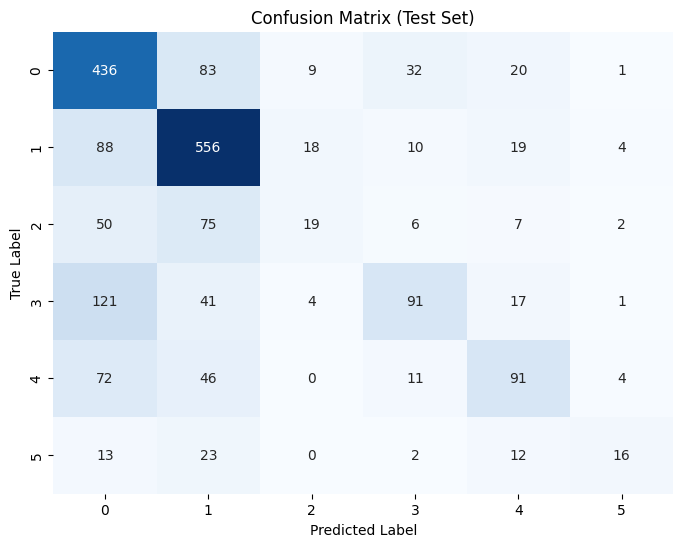

In [22]:
predictions = trainer.predict(token_data["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()


In [ ]:
predictions = trainer.predict(token_data["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test Macro-F1: {macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))

print("\nConfusion MAtrix:")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
